In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, LayerType, SamplingMethod, System, OptimizerType, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    r"\sigma_t^q": "sigq",
    r"\sigma_t^\theta": "sigtheta",
    r"\sigma_t^\eta": "sige",
    r"\mu_t^\eta": "mue",
    r"\mu_t^q": "muq",
    r"\mu_t^\theta": "mutheta",


    r"\rho": "rho",
    r"\underline{a}": "ah",
    r"\underline{\delta}": "deltah",
    r"\delta": "deltae",
    r"\sigma": "sig",
    r"\kappa": "kappa",

    r"\eta": "e",

    r"\theta": "theta",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "phi",

}

## basic

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 20,
 "lr": 1,
 "loss_log_interval": 1,
 "optimizer_type": "AdamW",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variabl

D:\Research\continuous-time-eco-models\deep_macrofin\models\kan\KAN.py:329: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


====================================Training====================================


Total loss: 0.0003: 100%|██████████| 20/20 [04:46<00:00, 14.31s/it]
C:\Users\User\AppData\Local\Temp\ipykernel_6776\1616312500.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

training finished, total time :: 286.24280285835266
Best model saved to ./models/BruSan14_log_utility_kan/model_best.pt if valid
Model saved to ./models/BruSan14_log_utility_kan/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
constraint_1: 0.0000,
endogeq_1: 0.0003,
endogeq_2: 0.0000,
total_loss: 0.0003


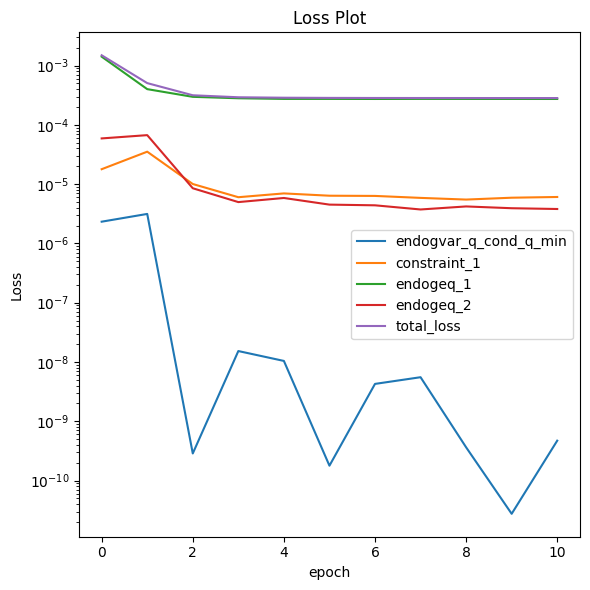

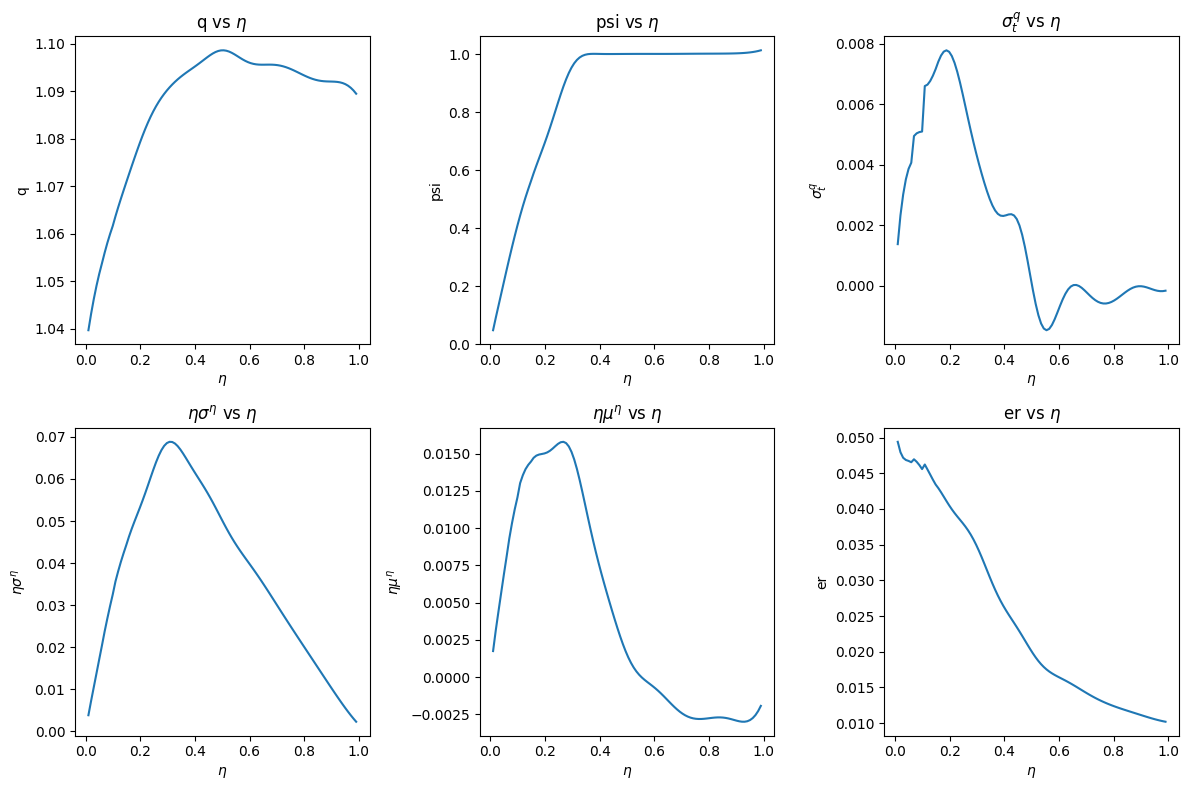

In [3]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"sampling_method": SamplingMethod.FixedGrid,
    "num_epochs": 20, "loss_log_interval": 1, "lr": 1}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True,
        "layer_type": LayerType.KAN,
        "hidden_units": [1, 5, 5, 5, 1], 
        "activation_type": ActivationType.ReLU,
        "grid": 10,
        "k": 10,
    },
    "psi": {
        "positive": True, 
        "layer_type": LayerType.KAN,
        "hidden_units": [1, 5, 5, 5, 1], 
        "activation_type": ActivationType.ReLU,
        "grid": 10,
        "k": 10,
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "(2*ah*kappa + (kappa*r)**2 + 1)**0.5 - kappa*r", pde_model.variable_val_dict,
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")
pde_model.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility_kan/model.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_kan", "model.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_kan/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_kan/model_best.pt"))
    pde_model.eval_model(True)
plot_loss_df(fn="./models/BruSan14_log_utility_kan/model_min_loss.csv", loss_plot_fn="./models/BruSan14_log_utility_kan/model_min_loss.jpg")
pde_model.plot_vars(["q", "psi",
                    r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)